# Data Wrangling
## Business Problem
Leukemia is a type of cancer of the blood that often affects young people. In the past, pathologists would diagnose patients by eye after examining blood smear images under the microscope. But, this is time consuming and tedious. Advances in image recognition technology have come a long ways since their inception. Therefore, automated solutions using computers would be of great benefit to the medical community to aid in cancer diagnoses.

The goal of this project is to address the following question: How can the doctor’s at the Munich University Hospital automate the diagnosis of patients with leukemia using images from blood smears?

**Plan:**
Address the following questions:
* How many different morphology classes are there in the dataset?
* What are the image counts per morphology class?
* For each morphology class, what percentage of samples were re-annotated?
* Are there any samples there were re-annoted only once?

In [1]:
import os
import sys
sys.path.append('..')

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src import constants as con
from src.visualization import visualize as viz

# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
%matplotlib inline

## Load Annotations File
The above questions can be answered by exmaining the annotations file, _annotations.dat_.

In [2]:
df_annotate = pd.read_csv(os.path.join(con.REFERENCES_DIR, 'annotations.dat'), sep=' ', 
                          names=['Image Dir', 'Morphology', 'First Re-Annotation', 'Second Re-Annotation'])

In [3]:
df_annotate.head()

,Image Dir,Morphology,First Re-Annotation,Second Re-Annotation
0,BAS/BAS_0001.tiff,BAS,NaN,NaN
1,BAS/BAS_0002.tiff,BAS,NaN,NaN
2,BAS/BAS_0003.tiff,BAS,NaN,NaN
3,BAS/BAS_0004.tiff,BAS,NaN,NaN
4,BAS/BAS_0005.tiff,BAS,NaN,NaN


In [26]:
num_images = len(df_annotate)
print(f'There are {num_images} images in the dataset.')

There are 18365 images in the dataset.


## Data Exploration
### Morphology Classes

**Questions:**
* How many images are there per morphology?
* For each morphology, how many were re-annoted?

In [4]:
df_annotate.groupby('Morphology').count().rename(columns={'Image Dir': 'Image Count'}).sort_values(by='Image Count', ascending=False)

,Image Count,First Re-Annotation,Second Re-Annotation
Morphology,,,
NGS,8484,525,525
LYT,3937,377,377
MYO,3268,657,657
MON,1789,233,233
EOS,424,46,46
NGB,109,7,7
BAS,79,5,5
EBO,78,15,15
PMO,70,12,12


**Observations:** 
* The category _NGC_ contains the most images.
* The category _MYO_ contains the most re-annotations.

### Unclassified Re-Annotations

**Questions:**
* How many images were unclassified after the first re-annotation, but not the second?

In [5]:
df_unc_first = df_annotate[(df_annotate['First Re-Annotation'] == 'UNC') & (df_annotate['Second Re-Annotation'] != 'UNC')]

In [6]:
df_unc_first.groupby('Morphology').count().rename(columns={'Image Dir': 'Image Count'}).sort_values(by='Image Count', ascending=False)

,Image Count,First Re-Annotation,Second Re-Annotation
Morphology,,,
MYO,6,6,6
LYT,4,4,4
EBO,3,3,3
MON,3,3,3
NGS,2,2,2
KSC,1,1,1


**Questions:**
* How many images were unclassified after the second re-annotation, but no the first?

In [7]:
df_unc_second = df_annotate[(df_annotate['First Re-Annotation'] != 'UNC') & (df_annotate['Second Re-Annotation'] == 'UNC')]

In [8]:
df_unc_second.groupby('Morphology').count().rename(columns={'Image Dir': 'Image Count'}).sort_values(by='Image Count', ascending=False)

,Image Count,First Re-Annotation,Second Re-Annotation
Morphology,,,
MYO,69,69,69
MON,33,33,33
LYT,29,29,29
NGS,26,26,26
EOS,2,2,2
EBO,1,1,1
MMZ,1,1,1
MOB,1,1,1
NGB,1,1,1


**Questions:**
* How many images were unclassified after both re-annotations?

In [9]:
df_unc_both = df_annotate[(df_annotate['First Re-Annotation'] == 'UNC') & (df_annotate['Second Re-Annotation'] == 'UNC')]

In [10]:
df_unc_both.groupby('Morphology').count().rename(columns={'Image Dir': 'Image Count'}).sort_values(by='Image Count', ascending=False)

,Image Count,First Re-Annotation,Second Re-Annotation
Morphology,,,
LYT,15,15,15
MYO,9,9,9
NGS,9,9,9
MON,7,7,7
KSC,2,2,2
BAS,1,1,1
MYB,1,1,1


### Mature vs. Immature Leukocytes
This dataset was used in the paper, [Human-level recognition of blast cells in acute myeloid leukemia with convolutional neural networks](https://www.biorxiv.org/content/10.1101/564039v1.full). In Figure 2 of this paper, the 15 morphological types can be split into two groups, mature leukocytes and immature leukocytes. According to the article, [Normal leukocytes](https://eclinpath.com/hematology/morphologic-features/white-blood-cells/normal-leukocytes/), from the Cornel Univesity College of Vetrinary Medicine, EclinPath textbook, mature leukocytes are associated with a healthy body, while immature leukocytes are associated with disease. Often, patients with leukemia release immature leokocytes. Therefore, with this information, I will create an additional column to tag weather a leukocyte morphology is in the mature or immature group.

In [11]:
mature = ['BAS', 'EOS', 'LYA', 'LYT', 'MON', 'NGB', 'NGS']
immature = ['EBO', 'MMZ', 'MOB', 'MYB', 'MYO', 'PMB', 'PMO']
smudge = ['KSC']

In [12]:
df_annotate['Maturity'] = np.nan

In [13]:
df_annotate.loc[df_annotate['Morphology'].isin(mature), 'Maturity'] = 'mature'

In [14]:
df_annotate.loc[df_annotate['Morphology'].isin(immature), 'Maturity'] = 'immature'

In [15]:
df_annotate.loc[df_annotate['Morphology'].isin(smudge), 'Maturity'] = 'smudge'

In [16]:
df_maturity = pd.concat([df_annotate['Maturity'].value_counts(), df_annotate['Maturity'].value_counts(normalize=True)], axis=1)
df_maturity.columns = ['Count', 'Percentage']

In [17]:
df_maturity

,Count,Percentage
mature,14833,0.807678
immature,3517,0.191506
smudge,15,0.000817


**Observations:**
There exists a class imbalance between mature and immature, with over 80% of the values being mature. This class imbalance will need to be addressed during the modeling phase.

### Examine Images
For each morphology class, I will view an image small, to gain an understanding of the visual features for each.

In [18]:
image_list = df_annotate.groupby('Morphology').first()['Image Dir'].tolist()

**Questions:**
* What is the image shape?
* What do the images look like?

In [19]:
img = mpimg.imread(os.path.join(con.RAW_IMAGES_DIR, image_list[0]))

In [20]:
print(f'The image shape is {img.shape}.')

The image shape is (400, 400, 4).


**Observations:**
The four color channels indicates that the TIFF images follow a CMYK format.

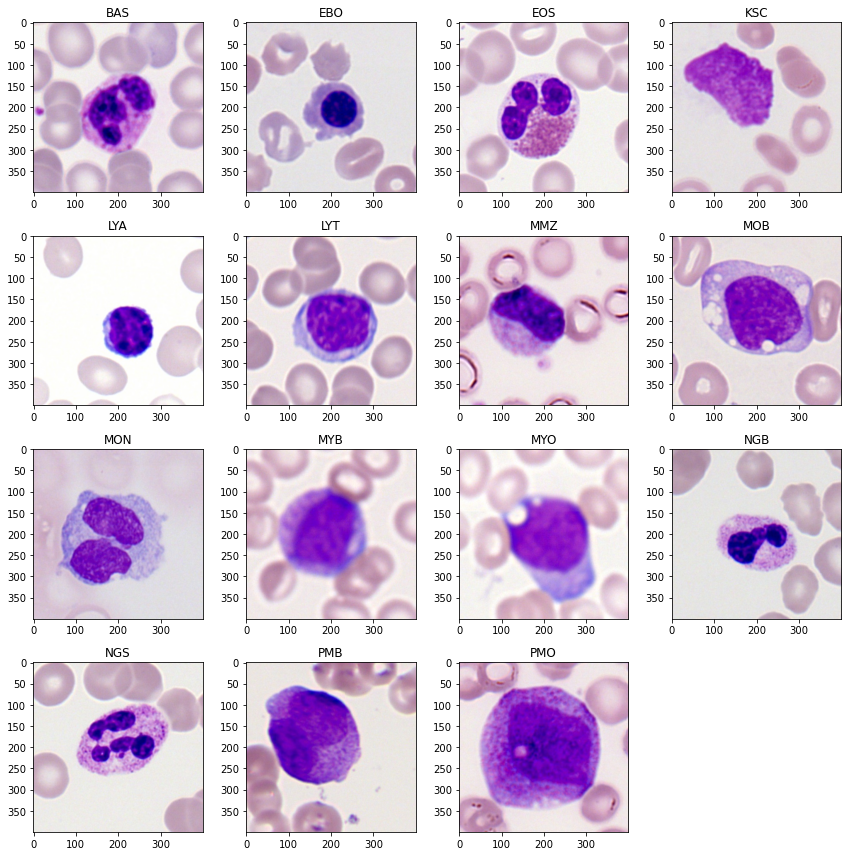

In [22]:
viz.display_images(image_list, 4)

In [23]:
df_annotate.head()

,Image Dir,Morphology,First Re-Annotation,Second Re-Annotation,Maturity
0,BAS/BAS_0001.tiff,BAS,NaN,NaN,mature
1,BAS/BAS_0002.tiff,BAS,NaN,NaN,mature
2,BAS/BAS_0003.tiff,BAS,NaN,NaN,mature
3,BAS/BAS_0004.tiff,BAS,NaN,NaN,mature
4,BAS/BAS_0005.tiff,BAS,NaN,NaN,mature


### Save Updated Annotations
Save the updated annotations file, with the additional column Maturity, to the references directory.

In [25]:
df_annotate.to_csv(os.path.join(con.REFERENCES_DIR, 'annotations_updated.csv'), index=False)

## Summary
* Dataset
    * There are 18365 images in the dataset.
    * Each image is of type TIFF.
    * The image's shape is (400, 400, 4).
        * Four channels indicates a CMYK color scheme.
* Morphologies
    * There are 15 morphologies.
    * The morphologies can be divided into two groups, depending on maturity of the leukocyte in the image.
        * Mature indicates healthy.
        * Immature indicates not healthy.
* Class Imbalance
    * There exists a class imbalance between the two groups, mature and immature, with over 80% of the images falling in mature.